In [1]:
!nvidia-smi

Fri Jan  5 14:03:26 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 528.24       Driver Version: 528.24       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| 30%   42C    P3    31W / 320W |      0MiB / 16376MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from data_provider import *
from model import *
from pytorch_metric_learning import losses
import torch.optim as optim

c:\Users\DAHS\anaconda3\envs\DL\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
mimic_data_dir = '/Users/DAHS/Desktop/ECP_CONT/ECP_SCL/Case Labeling/MIMIC-IV.csv.gz'
mimic_df = pd.read_csv(mimic_data_dir, compression = 'gzip', usecols = ['subject_id','classes'])

In [4]:
## Build Dataset 
print(f'Build Dataset ....')

dataset_train = TableDataset(data_path=mimic_data_dir, data_type='mimic',mode='train',seed=2582)

y_train_indices = dataset_train.df_num.index
y_train = [dataset_train.y[i] for i in y_train_indices]
class_sample_count = np.array([len(np.where(y_train == t)[0]) for t in np.unique(y_train)])

weight = 1. / class_sample_count
    
samples_weight = np.array([weight[t] for t in y_train])
samples_weight = torch.from_numpy(samples_weight)
sampler = WeightedRandomSampler(samples_weight.type('torch.DoubleTensor'), len(samples_weight))

loader_train = DataLoader(dataset_train, batch_size=128, shuffle=False, sampler=sampler, drop_last=True)

dataset_val = TableDataset(data_path=mimic_data_dir, data_type='mimic',mode='valid',seed=2582)
loader_val = DataLoader(dataset_val, batch_size=128, shuffle=False, drop_last=True)

# Tuple Containing the number of unique values within each category
card_categories = []
for col in dataset_train.df_cat.columns:
    card_categories.append(dataset_train.df_cat[col].nunique())

# dataset_test = TableDataset(data_path=args.mimic_data_dir, data_type='eicu',mode='test',seed=args.seed)
# loader_test = DataLoader(dataset_test, batch_size=1, shuffle=False, num_workers=4)

# # Tuple Containing the number of unique values within each category
# card_categories = []
# for col in dataset_test.df_cat.columns:
#     card_categories.append(dataset_test.df_cat[col].nunique())

Build Dataset ....
test set : test set = 0.7 : 0.30000000000000004
Train set class:  classes
0    73412
1    73412
2    13995
3    13995
Name: count, dtype: int64
Test set class:  classes
0    579948
1     31520
2      5986
3     67460
Name: count, dtype: int64
--------------------
Train class ratio: 0.8388778853486103:0.0459989059814493:0.008769066218198429:0.10635414245174193
Test class ratio: 0.8467457228206753:0.04602037628081774:0.00873978338886342:0.09849411750964354
--------------------
Number of trainset patient: 9554
Number of testset patient: 4201
Number of trainset stay: 10126
Number of testset stay: 4459
--------------------
Split seed:  2582
train ratio: 0.7
Threshold: 0.05
--------------------
총 소요 시간(초):1.5349442958831787
시도한 trial 수:  0
test set : test set = 0.7 : 0.30000000000000004
Train set class:  classes
0    73412
1    73412
2    13995
3    13995
Name: count, dtype: int64
Test set class:  classes
0    579948
1     31520
2      5986
3     67460
Name: count, dtype: 

In [5]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

SEED = 2582
seed_everything(seed = SEED)

In [6]:
import math
from torch.optim.lr_scheduler import _LRScheduler

class CosineAnnealingWarmUpRestarts(_LRScheduler):
    def __init__(self, optimizer, T_0, T_mult=1, eta_max=0.1, T_up=0, gamma=1., last_epoch=-1):
        if T_0 <= 0 or not isinstance(T_0, int):
            raise ValueError("Expected positive integer T_0, but got {}".format(T_0))
        if T_mult < 1 or not isinstance(T_mult, int):
            raise ValueError("Expected integer T_mult >= 1, but got {}".format(T_mult))
        if T_up < 0 or not isinstance(T_up, int):
            raise ValueError("Expected positive integer T_up, but got {}".format(T_up))
        self.T_0 = T_0
        self.T_mult = T_mult
        self.base_eta_max = eta_max
        self.eta_max = eta_max
        self.T_up = T_up
        self.T_i = T_0
        self.gamma = gamma
        self.cycle = 0
        self.T_cur = last_epoch
        super(CosineAnnealingWarmUpRestarts, self).__init__(optimizer, last_epoch)
    
    def get_lr(self):
        if self.T_cur == -1:
            return self.base_lrs
        elif self.T_cur < self.T_up:
            return [(self.eta_max - base_lr)*self.T_cur / self.T_up + base_lr for base_lr in self.base_lrs]
        else:
            return [base_lr + (self.eta_max - base_lr) * (1 + math.cos(math.pi * (self.T_cur-self.T_up) / (self.T_i - self.T_up))) / 2
                    for base_lr in self.base_lrs]

    def step(self, epoch=None):
        if epoch is None:
            epoch = self.last_epoch + 1
            self.T_cur = self.T_cur + 1
            if self.T_cur >= self.T_i:
                self.cycle += 1
                self.T_cur = self.T_cur - self.T_i
                self.T_i = (self.T_i - self.T_up) * self.T_mult + self.T_up
        else:
            if epoch >= self.T_0:
                if self.T_mult == 1:
                    self.T_cur = epoch % self.T_0
                    self.cycle = epoch // self.T_0
                else:
                    n = int(math.log((epoch / self.T_0 * (self.T_mult - 1) + 1), self.T_mult))
                    self.cycle = n
                    self.T_cur = epoch - self.T_0 * (self.T_mult ** n - 1) / (self.T_mult - 1)
                    self.T_i = self.T_0 * self.T_mult ** (n)
            else:
                self.T_i = self.T_0
                self.T_cur = epoch
                
        self.eta_max = self.base_eta_max * (self.gamma**self.cycle)
        self.last_epoch = math.floor(epoch)
        for param_group, lr in zip(self.optimizer.param_groups, self.get_lr()):
            param_group['lr'] = lr

In [7]:
import gc
gc.collect()

path_model = "./checkpoint"
if not os.path.exists(path_model):
    os.makedirs(os.path.join(path_model))

def param():
    categories = card_categories
    num_continuous = 196 
    dim = 32                       # Embedding Dimension of Input Data  32
    depth = 4                      # Nums of Attention Layer Depth  6
    heads = 8                      # Nums of Attention head
    dim_head = 17                  # Dimension of Attention(Q,K,V)
    attn_dropout = 0.1             # Ratio of Attention Layer dropout
    ff_dropout = 0.6215269253354271  # Ratio of FeedForward Layer dropout
    temp = 0.38413918034866346
    total_epoch = 50
    lr = 0.0001
    num_special_tokens = 2
    return categories, num_continuous, dim, depth, heads, dim_head, attn_dropout, ff_dropout, temp, total_epoch, lr, num_special_tokens

def train(trial, search = True):
    global emb_model, results_loss, optimizer, scheduler
    patience = 3
    early_stop_counter = 0
    categories, num_continuous, dim, depth, heads, dim_head, attn_dropout, ff_dropout, temp, total_epoch, lr, num_special_tokens = param()
    
    # search parameters
    if search == True:
        # total_epoch = trial.suggest_int('total_epoch', 4,10)
        dim      = trial.suggest_int('dim', 20,90)
        depth      = trial.suggest_int('depth', 3,5)
        ff_dropout = trial.suggest_uniform('FeedForward Layer dropout', 0.56, 0.65)
        temp       = trial.suggest_uniform('temp', 0.1, 0.5)
        
    print('learning_rate : ', lr, "\nepoch : ", total_epoch, "\nEmbedding Dimension of Input Data : ", dim, "\nNums of Attention Layer Depth : ", depth, "\ndrop_rate : ", ff_dropout, "\ntemperature : ", temp)
    
    results_loss = {
    'epoch_by_trn'          : [],
    'epoch_by_val'          : []
    }

    # 모델 정의
    emb_model = FTTransformer(categories=categories,
    num_continuous=num_continuous,
    dim=dim,
    depth=depth,
    heads=heads,
    dim_head=dim_head,
    num_special_tokens = 2,
    attn_dropout=attn_dropout,
    ff_dropout=ff_dropout).to(device)
    
    print(emb_model)
    
    contrastive_loss = losses.SupConLoss(temperature=temp)
    # optimizer = optim.RMSprop(emb_model.parameters(), lr= lr)
    optimizer = optim.AdamW(emb_model.parameters(), lr = 0.000001)
    scheduler = CosineAnnealingWarmUpRestarts(optimizer, T_0=15, T_mult=1, eta_max=0.01,  T_up=10, gamma=0.6)
    
    ## Model Train and Eval
    Best_valid_loss = 1e9
    for epoch in range(1, total_epoch+1):
        emb_model.train()
        running_loss = 0

        current_lr = optimizer.param_groups[0]["lr"]
        
        for num_iter, batch_data in enumerate(tqdm(loader_train)):


            optimizer.zero_grad()
            
            X_num, X_cat, label = batch_data
            X_num, X_cat, label = X_num.to(device), X_cat.to(device), label.to(device)

            latent, _ = emb_model(X_cat,X_num,True)
            label =  label.type(torch.LongTensor)
            
            # backward pass
            loss = contrastive_loss(latent, label)
            # loss = criterion(output, label.unsqueeze(dim = 1))
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            scheduler.step()  
            
        if num_iter % 3000 == 0:
                print("TRAIN: EPOCH %04d / %04d | ITER %04d / %04d | LOSS %.4f" %
                    (epoch, total_epoch, num_iter+1, len(loader_train), running_loss / (num_iter+1)))
        print(f'Epoch{epoch} / {total_epoch} Train Loss : {running_loss / len(loader_train)} Current learning rate : {current_lr}')
        # print(f'Epoch{epoch} / {total_epoch} Train Loss : {running_loss / len(loader_train)}')
        print(f'---------Epoch{epoch} Training Finish---------')
        
        with torch.no_grad():
            emb_model.eval()
            running_loss = 0

            for num_iter, batch_data in enumerate(tqdm(loader_val)):
                X_num, X_cat, label = batch_data
                X_num, X_cat, label = X_num.to(device), X_cat.to(device), label.to(device)
                
                latent,_ = emb_model(X_cat,X_num,True)
                loss = contrastive_loss(latent, label)
                # loss = criterion(output, label.unsqueeze(dim = 1))
                
                running_loss += loss.item()

            if num_iter % 3000 == 0:
                print("VALID: EPOCH %04d / %04d | ITER %04d / %04d | LOSS %.4f" %
                    (epoch, total_epoch, num_iter+1, len(loader_val), running_loss / (num_iter+1)))
                
        print(f'Epoch{epoch} / {total_epoch} Valid Loss : {running_loss / len(loader_val)}')


        if running_loss / len(loader_val) < Best_valid_loss:
            print(f'Best Loss {Best_valid_loss:.4f} -> {running_loss / len(loader_val):.4f} Update! & Save Checkpoint')
            Best_valid_loss = running_loss / len(loader_val)
            early_stop_counter = 0
            torch.save(emb_model.state_dict(),f'{path_model}/FTTransformer.pth')
        else:
            early_stop_counter += 1
        
        print(f'---------Epoch{epoch} Valid Finish---------')
        
    return running_loss / len(loader_val)

In [8]:
# def make_embeded_df(model_name): 
#     print()
#     print('Start Getting the latent space vector(Train, Valid sample)')
    
#     mimic_df = target_data.copy()
#     print(len(mimic_df))
#     information = mimic_df[['subject_id', 'stay_id', 'hadm_id']]
#     trn_x, trn_y  = load_data(mimic_df)
    
#     scaler        = MinMaxScaler()
#     trn_sclaed_x  = scaler.fit_transform(trn_x)

#     trn_tensor_x  = torch.FloatTensor(trn_sclaed_x)
#     trn_tensor_y  = torch.LongTensor(trn_y.values) 
    
    
#     n_feat = trn_tensor_x.shape[1]
        
#     train_dataset = TensorDataset(trn_tensor_x, trn_tensor_y)
#     for_latent_loader_trn  = torch.utils.data.DataLoader(dataset= train_dataset, batch_size=trn_tensor_x.shape[0], shuffle=False, drop_last=False)
    
    
#     start = time.time()
#     model_name.eval()
#     with torch.no_grad():
#         for X_l, y_l  in for_latent_loader_trn: # Full batch
                
#                 X_l  = X_l.to(device)
#                 latent_vector_train = model_name.forward(X_l)
                
#                 emb_train_x = pd.DataFrame(np.array(latent_vector_train.cpu()), index = original_index)
#                 emb_train = pd.concat([emb_train_x, pd.DataFrame(np.array(y_l))], axis = 1)
#                 # emb_train = pd.concat([information, emb_train], axis = 1)
#     end = time.time()            
#     print()
#     print('End, Time consume(min):{}'.format((end - start)/60))  
    
#     return emb_train

In [9]:
warnings.filterwarnings("ignore")
import os
import optuna

# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= '0'
os.environ['CUDA_LAUNCH_BLOCKING']= '1'
n_gpu             = 1
device            = torch.device('cuda:0')

# Set parameters

study = optuna.create_study(sampler=optuna.samplers.TPESampler(), direction="minimize")
study.optimize(train, n_trials = 30) 

pruned_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED]
complete_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-01-05 14:04:55,871] A new study created in memory with name: no-name-5f25a6be-c3ce-4514-a1cf-2158310123ee


learning_rate :  0.0001 
epoch :  50 
Embedding Dimension of Input Data :  31 
Nums of Attention Layer Depth :  5 
drop_rate :  0.6058754443068571 
temperature :  0.3387178797742324
FTTransformer(
  (categorical_embeds): Embedding(58, 31)
  (numerical_embedder): NumericalEmbedder()
  (transformer): Transformer(
    (layers): ModuleList(
      (0): ModuleList(
        (0): Attention(
          (norm): LayerNorm((31,), eps=1e-05, elementwise_affine=True)
          (to_qkv): Linear(in_features=31, out_features=408, bias=False)
          (to_out): Linear(in_features=136, out_features=31, bias=False)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (1): Sequential(
          (0): LayerNorm((31,), eps=1e-05, elementwise_affine=True)
          (1): Linear(in_features=31, out_features=248, bias=True)
          (2): GEGLU()
          (3): Dropout(p=0.6058754443068571, inplace=False)
          (4): Linear(in_features=124, out_features=31, bias=True)
        )
      )
      (1

100%|██████████| 1365/1365 [01:44<00:00, 13.11it/s]


Epoch1 / 50 Train Loss : 4.8443012890798265 Current learning rate : 0.0
---------Epoch1 Training Finish---------


100%|██████████| 5350/5350 [02:35<00:00, 34.33it/s]


Epoch1 / 50 Valid Loss : 2.5669558916359305
Best Loss 1000000000.0000 -> 2.5670 Update! & Save Checkpoint
---------Epoch1 Valid Finish---------


100%|██████████| 1365/1365 [01:42<00:00, 13.34it/s]


Epoch2 / 50 Train Loss : 4.844267505603832 Current learning rate : 0.0
---------Epoch2 Training Finish---------


100%|██████████| 5350/5350 [02:36<00:00, 34.08it/s]


Epoch2 / 50 Valid Loss : 2.5669558916359305
---------Epoch2 Valid Finish---------


100%|██████████| 1365/1365 [01:41<00:00, 13.40it/s]


Epoch3 / 50 Train Loss : 4.844285888112945 Current learning rate : 0.0
---------Epoch3 Training Finish---------


100%|██████████| 5350/5350 [02:34<00:00, 34.67it/s]


Epoch3 / 50 Valid Loss : 2.5669558916359305
---------Epoch3 Valid Finish---------


100%|██████████| 1365/1365 [01:41<00:00, 13.41it/s]


Epoch4 / 50 Train Loss : 4.844278640537471 Current learning rate : 0.0
---------Epoch4 Training Finish---------


100%|██████████| 5350/5350 [02:34<00:00, 34.53it/s]


Epoch4 / 50 Valid Loss : 2.5669558916359305
---------Epoch4 Valid Finish---------


100%|██████████| 1365/1365 [01:42<00:00, 13.25it/s]


Epoch5 / 50 Train Loss : 4.844279348631918 Current learning rate : 0.0
---------Epoch5 Training Finish---------


100%|██████████| 5350/5350 [02:36<00:00, 34.27it/s]


Epoch5 / 50 Valid Loss : 2.5669558916359305
---------Epoch5 Valid Finish---------


100%|██████████| 1365/1365 [01:40<00:00, 13.54it/s]


Epoch6 / 50 Train Loss : 4.8442779981173 Current learning rate : 0.0
---------Epoch6 Training Finish---------


100%|██████████| 5350/5350 [02:34<00:00, 34.73it/s]


Epoch6 / 50 Valid Loss : 2.5669558916359305
---------Epoch6 Valid Finish---------


100%|██████████| 1365/1365 [01:41<00:00, 13.47it/s]


Epoch7 / 50 Train Loss : 4.844274843306769 Current learning rate : 0.0
---------Epoch7 Training Finish---------


100%|██████████| 5350/5350 [02:34<00:00, 34.55it/s]


Epoch7 / 50 Valid Loss : 2.5669558916359305
---------Epoch7 Valid Finish---------


100%|██████████| 1365/1365 [01:42<00:00, 13.27it/s]


Epoch8 / 50 Train Loss : 4.844281776833447 Current learning rate : 0.0
---------Epoch8 Training Finish---------


100%|██████████| 5350/5350 [02:37<00:00, 34.05it/s]


Epoch8 / 50 Valid Loss : 2.5669558916359305
---------Epoch8 Valid Finish---------


100%|██████████| 1365/1365 [01:43<00:00, 13.15it/s]


Epoch9 / 50 Train Loss : 4.844274085956616 Current learning rate : 0.0
---------Epoch9 Training Finish---------


100%|██████████| 5350/5350 [02:34<00:00, 34.58it/s]


Epoch9 / 50 Valid Loss : 2.5669558916359305
---------Epoch9 Valid Finish---------


100%|██████████| 1365/1365 [01:43<00:00, 13.22it/s]


Epoch10 / 50 Train Loss : 4.844282842643095 Current learning rate : 0.0
---------Epoch10 Training Finish---------


100%|██████████| 5350/5350 [02:38<00:00, 33.69it/s]


Epoch10 / 50 Valid Loss : 2.5669558916359305
---------Epoch10 Valid Finish---------


 16%|█▌        | 216/1365 [00:16<01:27, 13.12it/s]
[W 2024-01-05 14:48:15,425] Trial 0 failed with parameters: {'dim': 31, 'depth': 5, 'FeedForward Layer dropout': 0.6058754443068571, 'temp': 0.3387178797742324} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Users\DAHS\anaconda3\envs\DL\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\DAHS\AppData\Local\Temp\ipykernel_15640\2966313273.py", line 85, in train
    loss.backward()
  File "c:\Users\DAHS\anaconda3\envs\DL\lib\site-packages\torch\_tensor.py", line 396, in backward
    torch.autograd.backward(self, gradient, retain_graph, create_graph, inputs=inputs)
  File "c:\Users\DAHS\anaconda3\envs\DL\lib\site-packages\torch\autograd\__init__.py", line 173, in backward
    Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
KeyboardInterrupt
[W 2024-01-05 14:48:15,427] Trial

KeyboardInterrupt: 

In [31]:
warnings.filterwarnings("ignore")
import os
import optuna

# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= '0'
os.environ['CUDA_LAUNCH_BLOCKING']= '1'
n_gpu             = 1
device            = torch.device('cuda:0')

model = train(trial=1, search = False)

{'hidden': [98, 65, 40]}
learning_rate :  0.0006 
epoch :  120 
drop_rate :  0.223573505016481 
temperature :  0.3137977865167101
Contrastive_Embedding(
  (encoder): Sequential(
    (0): Linear(in_features=214, out_features=98, bias=True)
    (1): BatchNorm1d(98, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.223573505016481, inplace=False)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=98, out_features=65, bias=True)
    (5): BatchNorm1d(65, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.223573505016481, inplace=False)
    (7): LeakyReLU(negative_slope=0.01)
    (8): Linear(in_features=65, out_features=40, bias=True)
    (9): BatchNorm1d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Dropout(p=0.223573505016481, inplace=False)
    (11): LeakyReLU(negative_slope=0.01)
  )
)
epoch 1  time: 78.0996sec trn_contrastive:  4.9233
epoch 2  time: 77.5303sec trn_contra

KeyboardInterrupt: 

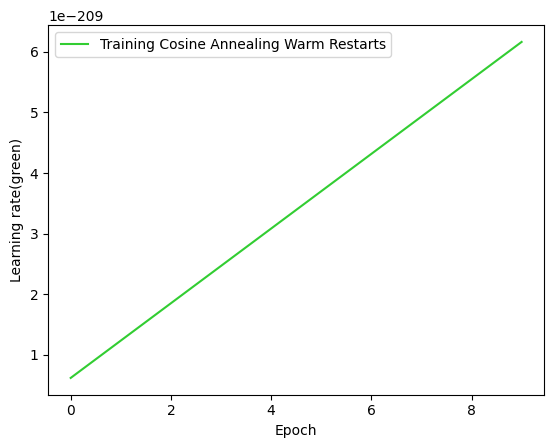

In [11]:
import matplotlib.pyplot as plt
lrs = []
for i in range(10):
    optimizer.step()
    lrs.append(optimizer.param_groups[0]["lr"])
    scheduler.step()


plt.plot(range(10), lrs, color = 'limegreen',  label = 'Training Cosine Annealing Warm Restarts')
plt.xlabel('Epoch')
plt.ylabel('Learning rate(green)')
plt.legend()
plt.show()

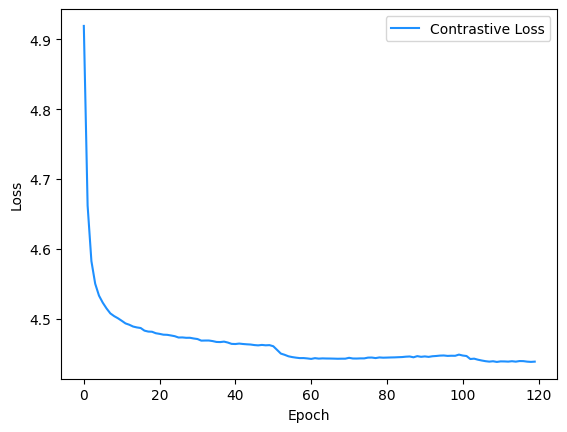

In [26]:
plt.plot(range(120),results_loss['epoch_by_trn'], color = 'dodgerblue', label = 'Contrastive Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [17]:
torch.save({"model_state_dict": model.state_dict(),
            },
           f"Contrastive_Embedding_Net(1117AE).pt")

In [54]:
print(model)

Contrastive_Embedding(
  (encoder): Sequential(
    (0): Linear(in_features=222, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.56, inplace=False)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.56, inplace=False)
    (7): LeakyReLU(negative_slope=0.01)
    (8): Linear(in_features=128, out_features=64, bias=True)
    (9): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Dropout(p=0.56, inplace=False)
    (11): LeakyReLU(negative_slope=0.01)
  )
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.56, inplace=False)
    (3): LeakyReLU(negative_slope=0.

In [18]:
emb_df = make_embeded_df(model)


Start Getting the latent space vector(Train, Valid sample)
818286

End, Time consume(min):0.09841051896413168


In [20]:
sample = pd.concat([dataset[['subject_id', 'stay_id', 'hadm_id']].reset_index(drop=True), emb_df.reset_index(drop=True)], axis = 1, ignore_index=True)
sample = sample.rename(columns = {0: 'subject_id', 1:'stay_id', 2:'hadm_id'})
sample

,subject_id,stay_id,hadm_id,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184
0,15332791,30003598,20683754,-0.001014,-0.009162,-0.009464,-0.001002,-0.000988,-0.009106,-0.009416,-0.009061,-0.009510,-0.000999,-0.001019,-0.009394,-0.009065,-0.000993,-0.009465,-0.009292,-0.009414,-0.009063,-0.001027,-0.009478,-0.009288,-0.009373,-0.001029,-0.009483,-0.008518,-0.009234,-0.009363,-0.009054,-0.009238,-0.001008,-0.009250,-0.009453,-0.009230,-0.009493,-0.009371,-0.009301,-0.009320,-0.001029,-0.009140,-0.001023,-0.001028,-0.009337,-0.009065,-0.009471,-0.009558,-0.009213,-0.009430,-0.009309,-0.009456,-0.009356,-0.009362,-0.001025,-0.001021,-0.001035,-0.009370,-0.009389,-1.033548e-03,-0.009285,-0.009166,-0.009313,-0.009333,-0.009467,-0.008837,-0.009275,-0.008142,-0.009303,-0.009602,-0.009177,-0.009367,-0.007936,-0.009302,-0.009367,-0.009460,-0.001046,-0.001006,-0.001023,-0.009440,-0.009383,-0.009410,-0.001024,-0.009276,-0.009462,-0.009312,-0.009202,-0.009274,-0.009259,-0.009174,-0.009142,-0.009488,-0.009448,-0.009330,-0.001023,-0.008025,-0.009363,-0.000988,-0.001019,-0.009590,-0.009362,-0.009161,-0.009398,-0.008683,-0.001001,-0.009491,-0.009557,-0.009275,-0.009317,-0.009408,-0.001010,-0.001008,-0.009300,-0.009451,-0.009306,-0.009206,-0.001004,-0.009422,-0.001021,-0.001012,-0.009244,-0.001021,-0.001018,-0.009380,-0.001021,-0.009279,-0.009660,-0.001005,-0.009348,-0.001009,-0.009439,-0.001048,-0.009281,-0.001029,-0.009491,-0.009398,-0.009379,-0.009317,-0.001008,-0.009379,-0.001011,-0.000994,-0.008322,-0.009528,-0.009209,-0.009175,-0.001023,-0.009396,-0.009037,-0.001002,-0.009413,-0.001009,-0.009416,-0.009291,-0.009421,-0.009411,-0.009273,-0.009410,-0.009351,-0.009103,-0.001015,-0.009423,-0.001018,-0.009166,-0.009409,-0.009423,-0.009473,-0.001024,-0.009293,-0.009384,-0.001020,-0.009617,-0.009393,-0.009280,-0.009501,-0.001018,-0.001024,-0.009511,-0.009249,-0.009229,-0.009345,-0.009345,-0.001010,-0.001001,1
1,15332791,30003598,20683754,-0.001003,-0.007288,-0.007451,-0.000990,-0.000978,-0.007154,-0.007484,-0.007209,-0.007576,-0.000989,-0.001007,-0.007447,-0.007117,-0.000982,-0.007538,-0.007402,-0.007486,-0.007225,-0.001018,-0.007545,-0.007335,-0.007459,-0.001019,-0.007549,-0.006784,-0.007350,-0.007437,-0.007102,-0.007348,-0.000998,-0.007353,-0.007526,-0.007352,-0.007554,-0.007345,-0.007303,-0.007397,-0.001018,-0.007278,-0.001013,-0.001017,-0.007417,-0.007215,-0.007545,-0.007584,-0.007325,-0.007496,-0.007334,-0.007505,-0.007454,-0.007461,-0.001013,-0.001012,-0.001024,-0.007456,-0.007464,-1.024011e-03,-0.007380,-0.007281,-0.007422,-0.007356,-0.007525,-0.006911,-0.007310,-0.006353,-0.007400,-0.007627,-0.007290,-0.007451,-0.006227,-0.007362,-0.007451,-0.007529,-0.001035,-0.000995,-0.001014,-0.007501,-0.007395,-0.007488,-0.001014,-0.007338,-0.007538,-0.007412,-0.007328,-0.007379,-0.007363,-0.007286,-0.007254,-0.007497,-0.007525,-0.007428,-0.001013,-0.006308,-0.007450,-0.000977,-0.001007,-0.007611,-0.007436,-0.007283,-0.007480,-0.006836,-0.000990,-0.007506,-0.007531,-0.007374,-0.007347,-0.007466,-0.001000,-0.000998,-0.007390,-0.007505,-0.007408,-0.007319,-0.000994,-0.007464,-0.001010,-0.001001,-0.007288,-0.001009,-0.001007,-0.007459,-0.001010,-0.007384,-0.007669,-0.000995,-0.007356,-0.000998,-0.007506,-0.001037,-0.007388,-0.001018,-0.007477,-0.007395,-0.007461,-0.007384,-0.000997,-0.007403,-0.001001,-0.000982,-0.006583,-0.007574,-0.007276,-0.007202,-0.001013,-0.007479,-0.007162,-0.000990,

In [22]:
sample.to_csv('embedding_data.csv')